In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from src.infra import DBConnection
from src.utils import numeric_statistics, prepare_data, RFMModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from src.utils import prepare_data_to_regression, ml_error
from category_encoders import CountEncoder
from sklearnex import patch_sklearn
import pickle


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

sns.set_style('darkgrid')
sns.set_palette('deep')

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1.0 Get Data 

Carregamento das variáveis de ambiente para poder acessar o banco de dados. 

In [2]:
load_dotenv()

host = os.getenv("DB_HOST")
porta = os.getenv("PORT") 
usuario = os.getenv("DB_USER") 
senha = os.getenv("DB_PASSWORD") 
schema = os.getenv("DB_SCHEMA") 
tabela = os.getenv("DB_TABLE")

Criei essa classe de acesso ao banco de dados para ficar menos verboso de código nesse notebook.

Para utilizar a classe e pegar os dados podemos fazer o seguinte:

```
conn = DBConnection(user=usuario, password=senha, host=host, port=porta, schema=schema)
df = conn.get_data()
```

In [3]:
# conn = DBConnection(user=usuario, password=senha, host=host, port=porta, schema=schema)
# df = conn.get_data()


# <font color="red">OBS</font>

Para não ficar fazendo consultas ao banco de dados todas as vezes que abrir esse notebook, decidi salvar
esses dados como um arquivo .csv nesse path `src/data/data.csv`. Mas não subirei esse arquivo para o GitHub,
pois não são dados públicos. Ou seja, só quem tem acesso é de fato quem tem acesso ao banco de dados.

In [4]:
path = "src/data/data.csv"
# df.to_csv(path)

In [5]:
df_raw = pd.read_csv(path, index_col=0)
df = df_raw.copy()

In [6]:
df.head()

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda
0,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,NaN,Smart TV,Origin ef2b,"0,0",1
1,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,NaN,Smart TV,Origin ef2b,"0,0",1
2,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,NaN,Smart TV,Origin ef2b,"0,0",1
3,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,NaN,Smart TV,Origin ef2b,"0,0",1
4,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,NaN,Smart TV,Origin ef2b,"0,0",1


# 2.0 Observações iniciais 

- purchase_id: Identificação da compra na Hotmart;
- product_id: Identificação do produto na Hotmart;
- affiliate_id: Identificação do afiliado na Hotmart;
- producer_id: Identificação do produtor na Hotmart;
- buyer_id: Identificação do comprador na Hotmart;
- purchase_date: Data e hora em que a compra foi realizada;
- product_creation_date: Data e hora em que o produto foi criado na Hotmart;
- product_category: categoria do produto na Hotmart. Exemplo: e-book,
software, curso online, e-tickets, etc.;
- product_niche: nicho de mercado que o produto faz parte. Exemplo:
educação, saúde e bem-estar, sexualidade, etc.;
- purchase_value: valor da compra. Esse dado, assim como nicho e categoria foi
codificado para manter a confidencialidade. O valor apresentado no dataset é
o z-score do valor real;
- affiliate_commission_percentual: percentual de comissão que o afiliado
receberá da compra;
- purchase_device: tipo de dispositivo utilizado no momento da compra, como:
Desktop, Mobile, Tablet, ou Outros;
- purchase_origin: endereço do site do qual a pessoa veio antes da compra. Por
exemplo, se uma pessoa veio do Facebook, Youtube, ou até mesmo de outra
página no site oficial do produto;
- is_origin_page_social_network: informa se essa compra veio de uma URL do
Facebook, Youtube, Instagram, Pinterest, ou Twitter.

## Algumas regras de negócio
- Quando a compra for feita diretamente pelo produtor, ou seja, quando não
houver afiliado intermediando a compra, o campo
affiliate_commission_percentual terá valor 0, e o campo affiliate_id será
igual ao producer_id;
- No campo purchase_origin nós apenas consideramos o host do site. Isso quer
dizer que, se uma pessoa veio do site www.meuproduto.com/promocoes,
esse campo só irá retornar o valor www.meuproduto.com;

Validação da primeira regra de negócio. Nesse caso não temos **nenhum** registro onde a compra foi feita
diretamente pelo produtor.

In [7]:
df[df['product_id'] == df['affiliate_id']]

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda


A coluna **purchase_origin** não possui um comportamento de host como **www.meuproduto.com**, mas irei considerar que a informação é essa mesmo. 

In [8]:
df['purchase_origin'].value_counts()

purchase_origin
Origin ef2b    330077
Origin 5187    167028
Origin adf0     77857
Origin 18eb     28693
Origin 3ade     13069
                ...  
Origin e51d         1
Origin d5eb         1
Origin 00ca         1
Origin 7475         1
Origin 290d         1
Name: count, Length: 9603, dtype: int64

## 2.2 SHAPE 

In [9]:
df.shape

(1599828, 15)

# 2.3 Data Types 

Interessante mudar os tipos das colunas de id, pois apesar de serem numéricas trazem uma informação categórica.

- Não faz sentido por exemplo realizar operações com o **product_id** por exemplo.
- Variável **Venda** possui valor numérico mas trás uma informação categorica (Acredito que seja de venda caso 1 ou não caso 0) Mas nesse dataset todos os registros possuem venda como 1. Ou seja, podemos fazer um drop dela posteriormente na criação do modelo de machine learning pois ela não traz nenhuma informação para o possível modelo, já que tem valores iguais para todos os registros.

In [10]:
df.dtypes

purchase_id                          int64
product_id                           int64
affiliate_id                         int64
producer_id                          int64
buyer_id                             int64
purchase_date                       object
product_creation_date               object
product_category                    object
product_niche                       object
purchase_value                     float64
affiliate_commission_percentual    float64
purchase_device                     object
purchase_origin                     object
is_origin_page_social_network       object
Venda                                int64
dtype: object

In [11]:
df.head()

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda
0,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,NaN,Smart TV,Origin ef2b,"0,0",1
1,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,NaN,Smart TV,Origin ef2b,"0,0",1
2,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,NaN,Smart TV,Origin ef2b,"0,0",1
3,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,NaN,Smart TV,Origin ef2b,"0,0",1
4,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,NaN,Smart TV,Origin ef2b,"0,0",1


# 2.4 Nenhum registro duplicado

In [12]:
df.columns.duplicated().any()

False

# 2.5 VARIÁVEIS NUMÉRICAS 

Essa análise estatística gosto de utilizar para poder identificar possíveis erros mias aparentes e para ter
uma ideia de como está a distribuição dos dados.

EXEMPLOS

- Podemos ver que o **purchase_value** tem uma alta skew e uma certa difernça entre a média e mediana. Sugerindo uma distribuição assimétrica à direita. Ou seja sugere que tem mais compras com preços menores (relativos à essa base)

In [13]:
df_numerics = df.select_dtypes(include=[int, float])
df_numerics = df_numerics[['purchase_value', 'affiliate_commission_percentual']]
numeric_statistics(df_numerics)

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
purchase_value,float64,32617,1.248490e-08,-0.349998,1.000000,-0.54124,124.561,125.10224,10.816902,629.205931
affiliate_commission_percentual,float64,279,7.596246e+00,0.000000,18.476731,0.00000,100.000,100.00000,2.259090,3.752811


# 2.4 VARIÁVEIS CATEGÓRICAS

In [14]:
df.head()

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda
0,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,NaN,Smart TV,Origin ef2b,"0,0",1
1,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,NaN,Smart TV,Origin ef2b,"0,0",1
2,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,NaN,Smart TV,Origin ef2b,"0,0",1
3,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,NaN,Smart TV,Origin ef2b,"0,0",1
4,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,NaN,Smart TV,Origin ef2b,"0,0",1


Aqui vamos dar uma olhada mais específica em 2 variáveis categóricas.

- **product_category**

Vemos aqui que a categoria **Phisical book** carrega mais de 80% das vendas dessa base de dados. Um valor bem grande.

- **product_niche**

Vemos que aqui que a distribuição é mais igualitária entre os nichos de conteúdos consumidos. Mas podemos ver que os 3 primeiros tem relação com determinado tipo desenvolvimento pessoal. No caso, negócios, melhoria da ansiedade e finanças. 

In [15]:
# product_category
df['product_category'].value_counts(normalize=True)

product_category
Phisical book      0.834221
Podcast            0.135465
Workshop           0.023906
eBook              0.002478
Subscription       0.001231
In-class course    0.000976
App                0.000973
eTicket            0.000529
Webinar            0.000184
Video              0.000036
Name: proportion, dtype: float64

In [16]:
# product_niche
df['product_niche'].value_counts(normalize=True)

product_niche
Negotiation               0.174969
Anxiety management        0.157314
Personal finance          0.116793
Presentation skills       0.087797
Immigration               0.059794
Government                0.058359
YouTube video creation    0.050134
Online course creation    0.037773
Careers                   0.033084
Organization              0.030398
Accounting                0.028566
Procrastination           0.025390
Economics                 0.025235
Biology                   0.020786
Media training            0.020437
Teaching English          0.016256
Filmmaking                0.013314
Child psychology          0.011826
Physics                   0.009192
Global diplomacy          0.008677
Genetics                  0.006347
Storytelling              0.004604
Disease                   0.002609
Thermodynamics            0.000343
Travel hacking            0.000003
Name: proportion, dtype: float64

# Transform Data to analysis

- **purchase_value** -> Dado que os dados estão codificados em uma escala fictícia, vou considerar que: Valores negativos não fazem sentido para uma venda. Logo irei trasnformar todos os valores negativos em positivos.

- **affiliate_commission_percentual** -> Possue valores NaN, poderia fazer alguma atribuição, mas como são somente 199 registros, optei por dropar os registros onde essas linhas são NaN.

- **purchase_id, product_id, affiliate_id, producer_id, buyer_id** -> Tranformar esses tipos para string.

- **is_origin_page_social_network** -> Veio como string, irei transformar para inteiro.

Para executar tal preparação dos dados criei uma função que se encontra em `src/utils/preprocess.py` 

In [17]:
df = prepare_data(df_raw)

# perguntas que seriam interessantes de serem respondidas 

### A Hotmart depende dos maiores produtores da plataforma? Ou seja, os produtores que mais vendem são responsáveis pela maior parte do faturamento da Hotmart?

In [18]:
df.head()

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda,purchase_value_positiva
199,10839481,118733,958412,958412,4984688,2016-01-01 00:04:44,2014-10-04 13:43:24,Phisical book,Organization,-0.428800,0.0,eReaders,Origin adf0,0,1,0.428800
200,10839484,181119,213339,213339,5917688,2016-01-01 00:05:27,2015-10-22 11:05:58,Phisical book,Organization,0.204131,0.0,Desktop,Origin 3c5a,0,1,0.204131
201,10839485,155827,2035132,2035132,718553,2016-01-01 00:05:29,2015-06-08 14:28:20,Podcast,Anxiety management,-0.377930,0.0,eReaders,Origin 14ad,0,1,0.377930
202,10839488,168608,3630929,3630929,5917691,2016-01-01 00:06:30,2015-08-18 14:41:40,Phisical book,Negotiation,-0.503885,0.0,eReaders,Origin 55a8,0,1,0.503885
203,10839491,130465,275005,275005,5550404,2016-01-01 00:06:50,2014-12-30 17:41:32,Phisical book,Media training,-0.415472,0.0,Desktop,Origin 659b,0,1,0.415472


In [19]:
df_top_10_maiores_faturamentos = df[['producer_id', 'purchase_value_positiva']].groupby("producer_id")\
.sum().reset_index().sort_values('purchase_value_positiva', ascending=False).head(10)

df_top_10_maiores_faturamentos\
.rename(
    columns={
        'producer_id': 'producer_id_mais_faturamento',
        'purchase_value_positiva': 'purchase_value_total'
    }, inplace=True)
df_top_10_maiores_faturamentos.reset_index(drop=True, inplace=True)

In [20]:
df_top_10_mais_vendem = df['producer_id'].value_counts().reset_index().head(10)
df_top_10_mais_vendem.rename(columns={'producer_id': 'producer_id_mais_vendem', 'count': 'qtd_de_vendas'}, inplace=True)

In [21]:
df_final = pd.concat([df_top_10_maiores_faturamentos, df_top_10_mais_vendem], axis=1)
df_final

,producer_id_mais_faturamento,purchase_value_total,producer_id_mais_vendem,qtd_de_vendas
0,42346,26309.795966,6697083,41220
1,6697083,17041.252187,3992235,39331
2,464846,15705.049530,464846,35468
3,3992235,14146.703215,349701,34565
4,3425706,9850.580539,166090,28895
5,2546880,9788.894025,442241,27796
6,166090,9411.283353,2307584,21716
7,3382787,9295.254940,3382787,20191
8,442241,9087.500313,4580574,16386
9,4580574,8535.123909,671256,16096



## Conclusão

SIM, dado esse nosso range de análise de **10 que mais vendem** e os **10 que mais dão lucro**. Como podemos ver

se fizermos um rank dos 10 produtores que mais vendem e dos 10 produtores que mais dão lucro, vemos que existem 7 nomes em comum entre esses dois ranks. Logo, entre os 10 que mais vendem, 7 fazem parte dos 10 que mais dão lucro.

In [22]:
lista_top_10_mais_vendem = df_final['producer_id_mais_vendem'].tolist()
df_final[df_final['producer_id_mais_faturamento'].isin(lista_top_10_mais_vendem)].reset_index(drop=True)

,producer_id_mais_faturamento,purchase_value_total,producer_id_mais_vendem,qtd_de_vendas
0,6697083,17041.252187,3992235,39331
1,464846,15705.049530,464846,35468
2,3992235,14146.703215,349701,34565
3,166090,9411.283353,2307584,21716
4,3382787,9295.254940,3382787,20191
5,442241,9087.500313,4580574,16386
6,4580574,8535.123909,671256,16096


### Existe algum padrão ou tendência relevante nos dados? 

Vemos que existe um padrão na quantidade de produtos criados ao longo dos anos. Como visto abaixo, a
quantidade produtos criados tem crescido ao longo dos anos, em outras palavras, existe uma tendência de 
crescimento dessa métrica ao longo dos anos. 

Podemos ver que ao longo de cada ano o número de produtos criados cresceu. Mas em 2016, foi o único ano
presente no dataset que a quantidade de produtos criados caiu. Isso pode está relacionado com a crise que 
vivemos no Brasil nesse mesmo ano.

Em 2016, o Brasil enfrentou uma crise política e econômica significativa. Durante esse ano, houve uma série de 
eventos que impactaram o país de maneira intensa. 

Uma das principais questões que ocorreram em 2016 foi o processo de impeachment da então presidente Dilma Rousseff. O processo foi resultado de uma série de acusações de irregularidades fiscais e políticas, levando a um agravamento da crise política no país. Em agosto de 2016, Dilma Rousseff foi afastada temporariamente da presidência pelo Senado e, posteriormente, destituída do cargo em definitivo.

Além disso, o Brasil enfrentou uma crise econômica nesse período. O país sofreu com uma recessão econômica, alta taxa de desemprego, queda nos investimentos e diminuição do crescimento econômico. Essa crise econômica foi resultado de uma combinação de fatores, incluindo a queda nos preços das commodities, desequilíbrios fiscais, escândalos de corrupção e instabilidade política.

In [23]:
df['product_creation_date_year'] = pd.to_datetime(df['product_creation_date']).dt.year.copy()

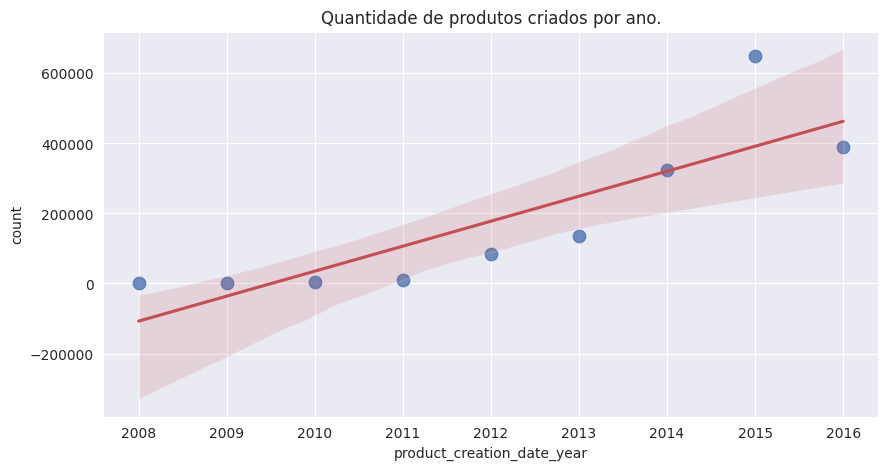

In [24]:
df_aux = df['product_creation_date_year'].value_counts().reset_index().sort_values("count")

sns.regplot(
    data=df_aux,
    x='product_creation_date_year',
    y='count',
    line_kws={"color": "C3"},
    scatter_kws={"s": 80},
)

plt.title("Quantidade de produtos criados por ano.");

Acompanhando o raciocínio acima, vemos que o valor das vendas totais por ano também aumentaram em uma proporção bem semelhante a do gráfico de cima.

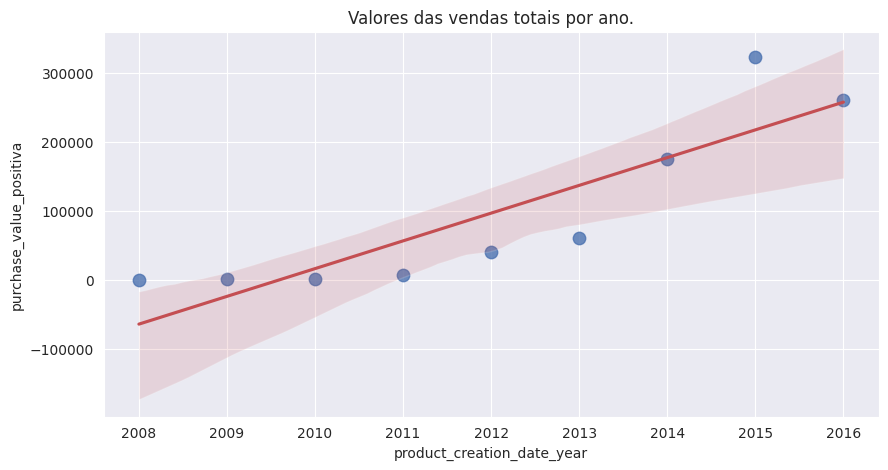

In [25]:
df_aux = df[['product_creation_date_year', 'purchase_value_positiva']].groupby("product_creation_date_year").sum().reset_index()

sns.regplot(
    data=df_aux,
    x='product_creation_date_year',
    y='purchase_value_positiva',
    line_kws={"color": "C3"},
    scatter_kws={"s": 80},
)

plt.title("Valores das vendas totais por ano.");

### É possível segmentar os usuários com base em suas características (faturamento, nicho de produto, etc.)? 

Poderíamos ter utilizado algum algoritmo de Machine learning nesse momento, mas optei por uma abordagem mais
simples e de fácil entendimento. Escolhi fazer essa segmentação de clientes utilizando o <mark>RFM model</mark>.

> O conceito da análise RFM, foi citado pela primeira vez em um artigo de Jan Roelf Bult e Tom Wansbeek, “Seleção ideal para mala direta“, publicado em uma edição de 1995 da Marketing Science. E foi criado para ajudar os profissionais de marketing a segmentar grupos específicos de clientes. 
> 
> A análise de RFM é baseada no principio de Pareto, que quando aplicado no marketing diz que 80% dos resultados vêm de 20% das causas. Da mesma forma, 20% dos clientes contribuem com 80% da sua receita total.
> 
> A análise RFM é um acrônimo para Recência, Frequência e Valor Monetário, e é uma ferramenta de análise de marketing e/ou para o time de CS (Customer Sucess) usada para identificar os melhores clientes de uma empresa ou organização usando determinadas medidas. O modelo RFM é baseado em três fatores quantitativos:
> 



- **Recência**: quão recentemente um cliente fez uma compra;
    - No nosso caso, agrupei por **buyer_id** e peguei a data mais recente que efetuou uma compra.
    
    
- **Frequência**: com que frequência um cliente faz uma compra;
    - No nosso caso, Agrupei por **buyer_id** e fiz a contagem de quantas vezes esse usuário apareceu na base.


- **Valor monetário**: quanto dinheiro um cliente gasta em compras;
    - Essa coluna já está presente no dataset como **purchase_value**, o que fiz foi agrupar por **buyer_id**
    e fazer a soma de quanto cada usuário já gastou num total.
    
Utilizaremos o formato dos quintils para poder atribuir notas para cada usuário para cada característica 
(Recência, Frequência e Valor monetário). Mas afinal, como funcionaria?

1. Pega cada coluns e ordena do menor para o maior a frequency e o monetary
    - Resumindo, as regras para a pontuação do RFM:

        - Quanto mais recente for a compra do cliente, maior será a pontuação de R.
        - Quanto mais compras o cliente realizar, maior será a pontuação de F;
        - Quanto maior for o gasto dele, maior será o score de M.

2. divide ele em cinco partes iguais
3. Para cada uma dessas partes, temos um score de 1 a 5 para aqueles que estiverem dentro daquele quintil,
sendo 5 a maior pontuação.

**Referências**: 
- http://vidadeproduto.com.br/analise-rfm/
- https://www.youtube.com/watch?v=CArRKwrLaeM&t=785s&ab_channel=ComunidadeDS

In [26]:
# preparação dos dados
df_prep = prepare_data(df_raw)

Após ter essa coluna `RFM_score` posso segmentar meus clientes. A mais comum são os 
11 segmentos a seguir:

Sendo `R=Recência`, `F=Frequência` e `M=Valor monetário`

| index | Segmento de clientes | Atividade | Valor de R | Valor médio de F e M
| ------| ------ | ----------- | ------- | ------ |
| 1 | Campeões |	Comprou recentemente. Compra com frequência. E gasta muito! | 4 a 5 | 4 a 5
| 2 | Clientes fieis |	Gasta um bom dinheiro. Com frequentemente. | 2 a 5 | 3 a 5
| 3 | Lealdade potêncial |	Clientes recentes. Gastaram uma boa quantia. Compraram mais de uma vez. | 3 a 5 | 1 a 3 |
| 4 | Clientes Recentes |	Comprou recentemente. Mas não com frequência. | 4 a 5 | 1 a 3
| 5 | Promissor	| Compradores recentes. Mas não gastaram muito. | 3 a 4 | 0 a 1
| 6 | Precisam de atenção | Recência, frequência e valores monetários acima da média. (Pode não ter comprado muito recentemente). | 2 a 3 | 2 a 3
| 7 | Prestes a “hibernar” | Abaixo da média da Recência, Frequência e valores monetários. (Os perderá se não for reativado). | 2 a 3 | 0 a 2
| 8 | Em risco | Gastou muito dinheiro e comprou com freqüência. Mas há muito tempo. (Precisa trazê-los de volta)! | 0 a 2 | 2 a 5
| 9 | Não posso perdê-los | Fez grandes compras e com frequência. Mas ha algum tempo. | 0 a 2 | 1 a 2
| 10 | Hibernando | A última compra foi feita a algum tempo. Pouco gasto e baixo número de pedidos. | 1 a 2 | 1 a 2
| 11 | Perdido | Recência, frequência e pontuação monetária mais baixas.| 0 a 2 | 0 a 2

Para simplificar nossa análise vamos utilizar a seguinte regra:
    
|Segmento de clientes | Valor médio de F e M
|------ | ------ |
| Campeões | 4 a 5
| Promissor | 2 a 4
| Hibernando | 0 a 2

Para Executar todo pipeline descrito criei uma classe presente em `src/utils/preprocess.py`.  

A classe se chama RFMModel o método `get_rfm_model`executa o pipeline princial descrito acima para obtenção desse modelo. Os testes unitários para os métodos dessa classe estão em `src/tests/test_preprocess.py`

In [27]:
rfm_model = RFMModel()
df_final = rfm_model.get_rfm_model(df_prep)

/home/marcos/Documentos/Projetos/test_hotmart/src/utils/preprocess.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.loc[:, self.recency_colum] = recency.copy()


In [28]:
df_final

,buyer_id,frequency_score,monetary_score,recency_score,RFM_score,FM_mean,clusters
0,7300108,1,1,4,2.000000,1.0,Hibernando
1,5874005,1,2,1,1.333333,1.5,Hibernando
2,6499728,1,3,1,1.666667,2.0,Hibernando
3,6499729,1,4,1,2.000000,2.5,Promissor
4,6499730,1,4,1,2.000000,2.5,Promissor
...,...,...,...,...,...,...,...
1100494,1128526,5,5,5,5.000000,5.0,Campeao
1100495,336781,5,5,5,5.000000,5.0,Campeao
1100496,701523,5,5,5,5.000000,5.0,Campeao
1100497,158226,5,5,5,5.000000,5.0,Campeao


Aqui após nossa clusterização vemos uma contagem das classificações de cada cluster. Podemos ver que tem
muitos consumidores segmentados como `promissor`.	

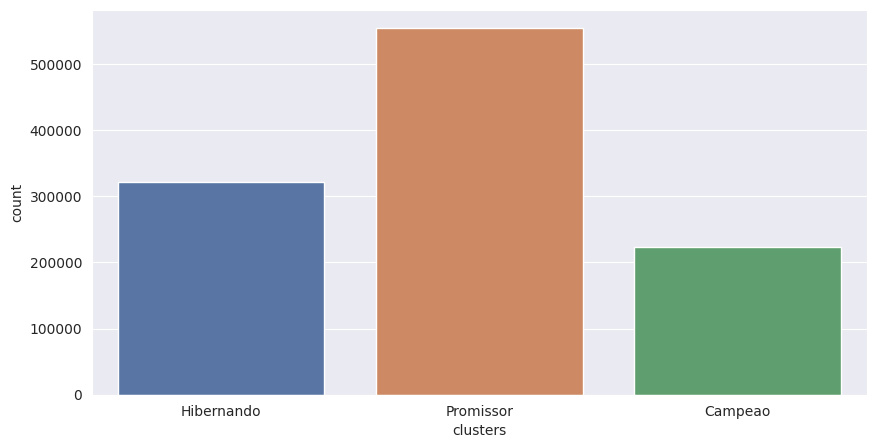

In [29]:
sns.countplot(data=df_final, x='clusters');

Nesse gráfico podemos ver um pouco da distribuição dos clusters seguindo a regra que definimos anteriormente. 

/home/marcos/miniconda3/envs/hotmart/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/marcos/miniconda3/envs/hotmart/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


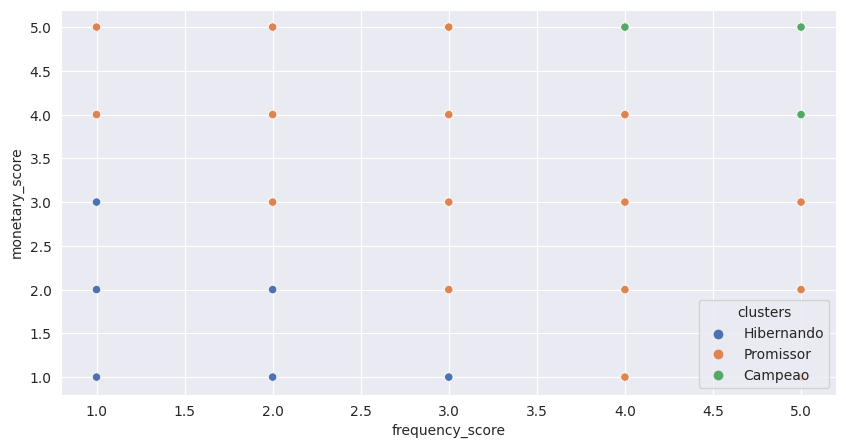

In [30]:
sns.scatterplot(
    data=df_final,
    x='frequency_score',
    y='monetary_score',
    hue='clusters'
);

### É possível estimar quanto de faturamento a Hotmart irá fazer nos próximos três meses a partir do último mês mostrado no dataset? 

Sim, podemos utilizar um modelo de regressão para poder prever esse valor baseado nos dados que tenho. 

In [31]:
df_raw = pd.read_csv(path, index_col=0)

df_raw['purchase_date'] = pd.to_datetime(df_raw['purchase_date'])
df_raw = df_raw.sort_values('purchase_date').reset_index(drop=True)


# TRAIN AND TEST

### <font color="red">IMPORTANTE</font>

Irei fazer uma amostra da base de dados total. Por dois motivos:

- Quantidade de dados muito grande para minha máquina local processar
- A finalidade não é necessariamente focar no resultado.

pegarei então assim 20.000 registros o que representa 1% da base total.

A divisão de treino e teste foi da seguinte forma, como se trata de um problema temporal, ordenei pela data
de compra e pegueis os 30% finais e utilizei para teste, enquanto os %70 iniciais usei
para treino.

Importante que essa divisão seja feita antes de qualquer etapa para simular o que acontece no ambiente de
produção e não existir vazamento de dados.

In [32]:
df_raw =df_raw.sample(20000)

# train and test
df_train = df_raw.head(14000)
df_test = df_raw.tail(6000)



### Preparações de dados para o machine learning

- purchase_value: Transformar para positivo todos os registros.
- affiliate_commission_percentual: Drop dos valores NaN.
- is_origin_page_social_network: Tranformar para números inteiros.
- purchase_id: Drop pois é uma informação não disponível no momento da predição.
- purchase_date: Como temos dados sómente do mês 1 do ano de 2016 poderíamis pegar somente o dia para essa coluna. Mas irei criar uma nova coluna chamada `period_of_day`. A qual vai seguir a regra que:
    - 0: Manhã, caso a hora da compra seja até 12h 
    - 1: Tarde, caso a hora da compra seja maior que 12h e menor ou igual a 18h
    - 2: Noite, caso a hora da compra esteja entre 18h e 00h
- Venda: Dropar essa coluna, pois não traz informação nenhuma para nosso conjunto de dados, já que
todos os registros estão com valor 1.
- product_creation_date: A partir dessa coluna pegaremos o ano, mes e dia.

Fiz uma abstração na preparação dos dados que está presente em `src/utils/machine_learning.py`. A função é `prepare_data_to_regression`

In [33]:
df_train = prepare_data_to_regression(df_train)

In [34]:
x_train = df_train.drop('purchase_value', axis=1).copy()
y_train = df_train['purchase_value'].copy()

In [35]:
num_columns = x_train.select_dtypes(include=[int, float]).columns.tolist()
cat_columns = list(set(x_train.columns.tolist()) - set(num_columns)) 


## Pipeline

Segue a baixo o pipeline de machine learning para criação do modelo de regressão.

### <font color="red">IMPORTANTE</font>

O ideal seria fazer o teste com vários modelos de machine learning para poder comparar entre eles e de fato
escolher um. Optei por escolher pela RandomForest por 3 motivos:

1. É um algoritmo que na maioria dos problemas que resolvi se sai muito bem.
2. Tempo para testar outros modelos
3. A Random Forest possui a importância de features que vai servir para responder outra questão de negócio.

In [36]:
num = Pipeline([
    ('mediana', SimpleImputer(strategy='median'))
])

cat = Pipeline([
    ('freq', SimpleImputer(strategy='most_frequent'))
])

fillna = ColumnTransformer(transformers=[
    ('num', num, num_columns),
    ('freq', cat, cat_columns)
])


pipe = Pipeline([
    ('fillna', fillna),
    ('on', CountEncoder()),
     ('scaler', StandardScaler()),
     ('clf', RandomForestRegressor())
 ])

In [37]:
pipe.fit(x_train, y_train.to_numpy())

Pipeline(steps=[('fillna',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mediana',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['product_id', 'affiliate_id',
                                                   'producer_id', 'buyer_id',
                                                   'affiliate_commission_percentual',
                                                   'is_origin_page_social_network',
                                                   'period_of_day', 'year',
                                                   'month', 'day']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['product_category',
                                                   'purchase_origin',
                                                   'purchase_device',
                                                   'product_niche'])])),
                ('on',
                 CountEncoder(cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                    13],
                              combine_min_nan_groups=True)),
                ('scaler', StandardScaler()),
                ('clf', RandomForestRegressor())])

Otimização de hiperparâmetros com cross-validation.

```
params = {
    'clf__n_estimators': [100, 500, 1000],
    'clf__max_depth': list(range(1,10)),
}

model = RandomizedSearchCV(estimator=pipe, param_distributions=params, scoring='r2', cv=5, n_iter=15, verbose=True)
model.fit(x_train, y_train.to_numpy())
```

Salvando o modelo para que não seja preciso rodar todas as vezes que abrir o notebook.

```
pickle.dump(pipe, open('src/model/randomForestModel.pkl', 'wb' ) )
```

In [39]:
with open('src/model/randomForestModel.pkl', 'rb') as file:
    model = pickle.load(file)

Encapsulei esse método `ml_error` presente em `src/utils/machine_learning.py` para poder calcular os erros
MAE, MAPE e RMSE de forma rápida.

In [40]:
yhat = model.predict(x_train)
df_erros = ml_error('Random Forest', y_train, yhat)
df_erros

,Model Name,MAE,MAPE,RMSE
0,Random Forest,0.185911,1.333964,0.535623



### Voltando à questão

*É possível estimar quanto de faturamento a Hotmart irá fazer nos próximos três meses a partir do último mês 
mostrado no dataset?*  

<font color="green">**SIM**</font>. Com este modelo apresentado podemos fazer a previsão da variável `purchase_value` pra o pŕoximo mês. Faríamos então a previsão de produtos vendidos no próximo mês, e daí então
somaríamos esses valores e teríamos o resultado para o mês.

### Quais características mais impactam no sucesso de um produto? Ou seja, o que faz um produto vender mais? 

Como dito anteriormente, o algoritmo da Random Forest fornece essa importância de features para as decisões
do modelo ao longo do processo. 

Como visto no gráfico abaixo as características que mais influenciam o modelo são:

1. **is_origin_page_social_network**: informa se essa compra veio de uma URL do Facebook, Youtube, Instagram, Pinterest, ou Twitter.
2. **product_id**: Identificação do produto na Hotmart;
3. **month**: Feature criada a parti da coluna `product_creation_date`.

In [41]:
importances = model.steps[-1][1].feature_importances_

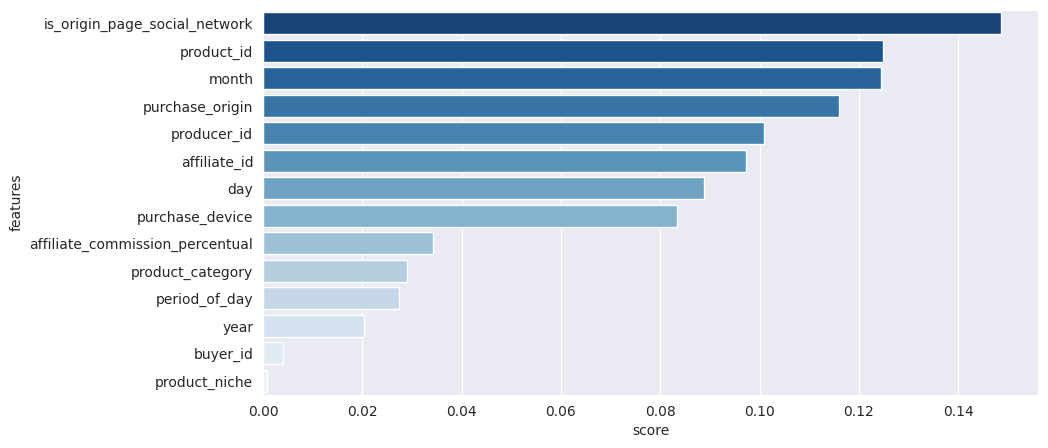

In [42]:
indices = np.argsort( importances )[::-1]

df = pd.DataFrame()

for i,j in zip(x_train, importances):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis=0 )
    
# plot
features = pd.DataFrame( {'features': x_train.columns, 'score': importances} ).sort_values( 'score', ascending=False )
sns.barplot( data=features, x='score', y='features', palette='Blues_r');